Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
External surrogate Model Evaluation: - MSE: 0.0003, R2: 0.9941
Spearman Correlation: 0.9964
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.5188
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.6937
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.4157
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.6478
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.7346
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.6761
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.4835
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.6511
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.7043
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.7330
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.7195
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.5548
Internal Surrogate Mo

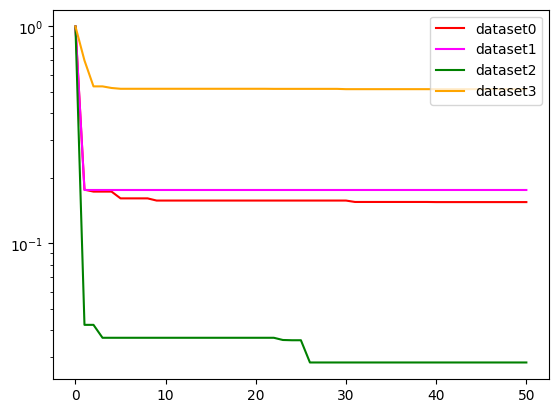

In [2]:
!pip install ConfigSpace
from google.colab import drive
import argparse
from scipy.stats import spearmanr
import typing
import ConfigSpace
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import sklearn.impute
import scipy.stats as sps
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel as C
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

class RandomSearch(object):

    def __init__(self, config_space: ConfigSpace.ConfigurationSpace):
        self.config_space = config_space

    def initialize(self, capital_phi: typing.List[typing.Tuple[typing.Dict, float]]) -> None:
        pass

    def select_configuration(self) -> ConfigSpace.Configuration:
        return self.config_space.sample_configuration(1)

    def update_runs(self, run: typing.Tuple[typing.Dict, float]):
        pass

class SurrogateModel:

    def __init__(self, config_space):
        self.config_space = config_space
        self.df = None
        self.model = None

    def fit(self, df):
        """
        Receives a data frame, in which each column (except for the last two) represents a hyperparameter, the
        penultimate column represents the anchor size, and the final column represents the performance.

        :param df: the dataframe with performances
        :return: Does not return anything, but stores the trained model in self.model
        """
        self.df = df
        x = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        # fit the external surrogate model using OneHotEncoder
        categorical_features = x.select_dtypes(include=['object']).columns.tolist()
        numerical_features = x.select_dtypes(include=['number']).columns.tolist()
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', sklearn.impute.SimpleImputer(strategy='mean'), numerical_features),
                ('cat', OneHotEncoder(), categorical_features)
            ])

        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=1000, random_state=40))
        ])
        model.fit(x_train, y_train)
        self.model = model

        pred = model.predict(x_test)
        mse = mean_squared_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        corr, _ = spearmanr(y_test, pred)
        print(f"External surrogate Model Evaluation: - MSE: {mse:.4f}, R2: {r2:.4f}")
        print(f"Spearman Correlation: {corr:.4f}")


    def predict(self, theta_new):
        """
        Predicts the performance of a given configuration theta_new

        :param theta_new: a dict, where each key represents the hyperparameter (or anchor)
        :return: float, the predicted performance of theta new (which can be considered the ground truth)
        """
        if self.model == None:
            raise ValueError("Train the model first.")
        # fill the keys without full dictionary with default values of the config space
        else:
            for key in dict(self.config_space).keys():
                if key not in theta_new.keys():
                    theta_new[key] = dict(self.config_space)[key].default_value
            list_theta = [theta_new]
            x_test = pd.DataFrame(list_theta)
            x_test = x_test[self.df.keys()[:-1]]
        # predict the performance as ground truth

            y_test = self.model.predict(x_test)
            return y_test[0]

class SequentialModelBasedOptimization(object):

    def __init__(self, config_space):
        """
        Initializes empty variables for the model, the list of runs (capital R), and the incumbent
        (theta_inc being the best found hyperparameters, theta_inc_performance being the performance
        associated with it)
        """
        self.config_space = config_space
        self.R = []
        self.theta_inc = None
        self.theta_inc_performance = None
        self.model = None

    def initialize(self, capital_phi: typing.List[typing.Tuple[typing.Dict, float]]) -> None:
        """
        Initializes the model with a set of initial configurations, before it can make recommendations
        which configurations are in good regions. Note that we are minimising (lower values are preferred)

        :param capital_phi: a list of tuples, each tuple being a configuration and the performance (typically,
        error rate)
        """
        for (c, p) in capital_phi:
            self.R.append((c, p))

            if self.theta_inc is None or p < self.theta_inc_performance:
                self.theta_inc = c
                self.theta_inc_performance = p
    def fit_model(self) -> None:
        """
        Fits the internal surrogate model on the complete run list.
        """
        # key = list(dict(self.config_space).keys())
        Rs = []
        for (c, p) in self.R:
            c = pd.DataFrame([c])
            p = [p]
            p = pd.DataFrame(p, columns=['score'])
            R_ = pd.concat([c, p], axis=1)
            Rs.append(R_)
        df = pd.concat(Rs, axis=0)
        x = df.iloc[:, :-1]
        y = df.iloc[:, -1]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        categorical_features = x.select_dtypes(include=['object']).columns.tolist()
        numerical_features = x.select_dtypes(include=['number']).columns.tolist()
        preprocessor = ColumnTransformer(
            transformers=[('num',
                           Pipeline([
                               ('imputer', SimpleImputer(strategy='mean')),
                               ('scaler', StandardScaler())
                               ]), numerical_features),
                               ('cat', OneHotEncoder(), categorical_features)
                               ])

        # GaussianProcessRegressor as internal surrogate model
        kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', GaussianProcessRegressor(kernel=kernel, alpha=1e-4,
                                                   normalize_y=True, random_state=40,
                                                   n_restarts_optimizer=30))])
        model.fit(x_train, y_train)
        self.model = model

        pred = self.model.predict(x_test)
        mse = mean_squared_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        print(f"Internal Surrogate Model Evaluation: - MSE: {mse:.4f}, R2: {r2:.4f}")

        self.theta_inc = x.iloc[np.argmin(y)]
        self.theta_inc_performance = y.iloc[np.argmin(y)]

    def select_configuration(self) -> ConfigSpace.Configuration:
        """
        Determines which configurations are good, based on the internal surrogate model.
        Note that we are minimizing the error, but the expected improvement takes into account that.
        Therefore, we are maximizing expected improvement here.

        :return: A size n vector, same size as each element representing the EI of a given
        configuration
        """

        num_candidates = 200
        # smbo.select configuration(sample configurations(many))
        configs = [dict(self.config_space.sample_configuration()) for _ in range(num_candidates)]
        for config in configs:
            for hp in list(self.config_space.values()):
                if hp.name not in config.keys():
                    config[hp.name] = hp.default_value

        configs_df = pd.DataFrame(configs)
        e = self.expected_improvement(self.model, self.theta_inc_performance, configs_df)
        configure = configs[np.argmax(e)]
        return configure

    @staticmethod
    def expected_improvement(model_pipeline: Pipeline, f_star: float, theta: np.array) -> np.array:
        """
        Acquisition function that determines which configurations are good and which
        are not good.

        :param model_pipeline: The internal surrogate model (should be fitted already)
        :param f_star: The current incumbent (theta_inc)
        :param theta: A (n, m) array, each column represents a hyperparameter and each row
        represents a configuration
        :return: A size n vector, same size as each element representing the EI of a given
        configuration
        """
        mu, sigma = model_pipeline.predict(theta, return_std=True)
        sigma = sigma.reshape(-1, 1)
        mu = mu.reshape(-1, 1)

        improvement = f_star - mu

        with np.errstate(divide='warn'):
            Z = np.where(sigma > 0, improvement / sigma, 0)
            ei = improvement * sps.norm.cdf(Z) + sigma * sps.norm.pdf(Z)
            ei[sigma == 0.0] == 0.0
        return ei.ravel()

    def update_runs(self, run: typing.Tuple[typing.Dict, float]):
        """
        After a configuration has been selected and ran, it will be added to the run list
        (so that the model can be trained on it during the next iterations).

        :param run: A tuple (configuration, performance) where performance is error rate
        """
        (c, p) = run

        self.R.append((c, p))

        if p < self.theta_inc_performance:
            self.theta_inc = c
            self.theta_inc_performance = p



def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--config_space_file', type=str, default='/content/drive/MyDrive/lcdb_config_space_knn.json')
    parser.add_argument('--configurations_performance_file', type=str, default='lcdb_configs.csv')
    parser.add_argument('--configurations_performance_file_1', type=str, default='config_performances_dataset-6.csv')
    parser.add_argument('--configurations_performance_file_2', type=str, default='config_performances_dataset-11.csv')
    parser.add_argument('--configurations_performance_file_3', type=str, default='config_performances_dataset-1457.csv')

    # max_anchor_size: connected to the configurations_performance_file. The max value upon which anchors are sampled
    parser.add_argument('--max_anchor_size', type=int, default=1600)
    parser.add_argument('--num_iterations', type=int, default=50)

    return parser.parse_known_args()[0]

def run(args):
    config_space = ConfigSpace.ConfigurationSpace.from_json(args.config_space_file)
    df_list = []
    df_1 = pd.read_csv(args.configurations_performance_file)
    df_2 = pd.read_csv(args.configurations_performance_file_1)
    df_3 = pd.read_csv(args.configurations_performance_file_2)
    df_4 = pd.read_csv(args.configurations_performance_file_3)
    df_list.append(df_1)
    df_list.append(df_2)
    df_list.append(df_3)
    df_list.append(df_4)
    colors = ['red', 'magenta', 'green', 'orange']
    i = 0
    for df in df_list:
      surrogate_model_smbo = SurrogateModel(config_space)
      surrogate_model_smbo.fit(df)

      smbo = SequentialModelBasedOptimization(config_space)
      initial_runs = []

      configs = [dict(config_space.sample_configuration()) for _ in range(200)]
      for config in configs:
          config['anchor_size'] = args.max_anchor_size
          config['score'] = surrogate_model_smbo.predict(config)

      configs_ = configs.copy()
      for c in configs_:
          c = c.pop('anchor_size')
      variables = list(df.keys())
      variables.remove('anchor_size')
      df_config = pd.DataFrame([[i[j] for j in variables] for i in configs_], columns=variables)
      m, n = df_config.shape

      for _, row in df_config.iterrows():
          config = dict(row.head(n-1))
          p = row['score']
          initial_runs.append((config, p))
      smbo.initialize(initial_runs)

      results_BO = {
          'BO': [1.0]
          }

      for idx in range(args.num_iterations):
          smbo.fit_model()
          theta_new = smbo.select_configuration()
          theta_new['anchor_size'] = args.max_anchor_size
          theta_new_ = theta_new.copy()
          performance = surrogate_model_smbo.predict(theta_new)
          del theta_new_['anchor_size']
          results_BO['BO'].append(min(results_BO['BO'][-1], performance))
          smbo.update_runs((theta_new_, performance))

      print(min(results_BO['BO']))
      plt.plot(range(len(results_BO['BO'])), results_BO['BO'], color=colors[i], label='dataset'+str(i))
      plt.yscale('log')
      i += 1
    plt.legend(loc="upper right")
    plt.show()

if __name__ == '__main__':
    run(parse_args())